# In this assignment, a simple ConvNet is implemented and trained to predict the language of a surname from its spelling in English.

In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. ConvNet class implementation

In [214]:
class ConvNet:
    """
    A simple ConvNet implementation with 2 convolutional layers 
    followed by a fully connected layer and a softmax output 
    layer.
    
    Attributes:
        n: A list of the number of filters applied at each convo-
            lutional layer.
        k: A list of the width of the filter window applied in each
            convolutional layer.
        input_dim: dimensionality of input
        output_dim: dimensionality of output
        nlen_list: List with the number of columns of the input when in its original form
            before being vectorized, for each layer.
        eta: initial learning rate value
        rho: momentum constant term
        F: list of filters/weights for each one of the convolutional
            layers.
        W: Weights of the fully connected layer
        
    """
    
    def __init__(self, n, k, output_dim, input_dim, nlen, eta = 0.001, rho = 0.9, he_init = False):
        """
        Initializes the convolutional neural network
    
        Args:
            he_init: When True He-initialization is performed for the weights
            nlen: Number of columns of the input when in its original form
            before being vectorized.
        Raises:
            Exception if the size of n and k is not the same.
        """
        if(len(n) != len(k)):
            raise Exception("The number of layers specified by <n> " \
                            "and <k> should be equal.")
        self.n = list(n)
        self.k = list(k)
        
        self.input_dim = input_dim
        
        # TODO: Change He initialization for first layer due to the sparse nature of the input
        self.F = []
        if he_init is True:
            self.F.append(np.random.normal(0, np.sqrt(2/nlen), (input_dim, self.k[0], self.n[0])))
        else:
            self.F.append(np.random.normal(0, 1, (input_dim, self.k[0], self.n[0])))
        self.nlen_list = [nlen - self.k[0] + 1]
        
        for i in range(1, len(n)):
            if he_init is True:
                self.F.append(np.random.normal(0, np.sqrt(2/self.nlen_list[-1]), (self.n[i - 1], self.k[i], self.n[i])))
            else:
                self.F.append(np.random.normal(0, 1, (self.n[i - 1], self.k[i], self.n[i])))
            self.nlen_list.append(self.nlen_list[-1] - self.k[1] + 1)
        fsize = self.n[-1] * self.nlen_list[-1]
        if he_init is True:
            self.W = np.random.normal(0, np.sqrt(2/self.nlen_list[-1]), (output_dim, fsize))
        else:
            self.W = np.random.normal(0, 1, (output_dim, fsize))
            
    def constructFilterMatrix(self, F, nlen):
        """
        Constructs the matrix of the filters of a layer used to
        perform the convolution by matrix multiplication.
        
        Args:
            F: A N x k x nf containing the convolutional filters
                of a certain layer where N is the height of the convo-
                lutional filter, k is its width and nf is the number of
                filters in the layer.
            nlen: Number of columns in the input of that layer. 
        
        Returns:
            An (nlen - k + 1) * nf x nlen * N matrix that can be used to
            perform the convolution when multiplied by the
            vectorized input.
        """
        nf = F.shape[2]
        vec_filters = F.reshape(F.shape[0] * F.shape[1], nf).T
        MF_matrix = np.zeros(((nlen - F.shape[1] + 1) * nf, nlen * F.shape[0]))
        cur_column = 0
        # For each time the filters are applied
        for i in range(nlen - F.shape[1] + 1):
            # Fill in the zero slots of the MF_Matrix with the vectorized filters
            MF_matrix[i * nf: i * nf + nf, cur_column *  F.shape[0]: cur_column *  F.shape[0] + vec_filters.shape[1]] = vec_filters
            cur_column += 1
        return MF_matrix
        
    def performLayerConvolutions(self, vec_input, height, width, filter_no):
        """
        Performs all convolutions at a given layer
        
        Args:
            vec_input: Vectorized version of the input to the convolutional
                layer.
            height: corresponding height of the filter
            width: corresponding width of the filter
            filter_no: number of filters to be applied
            
        Returns:
            A (nlen -k + 1) * filter_no x k * filter_no * height with the
            results of the convolutions.
        """
        pass

## 2. Preparing data

In [215]:
def encodeString(string, character_dictionary, max_length):
    """
    One-hot encodes the character string, converting each 
    of its letters to one-hot encoded vectors and stacking
    them from left to right. 
    
    Args:
        name: The string to be encoded.
        character_dictionary: A dictionary which has a unique
            index for each character in the alphabet used by
            the string.
        max_length: maximum length of the string. If the string
            has a length less than max_length, zero columnds are
            added as padding after the encoded character columns.

    
    Returns:
        A C x max_length vector with the one-hot encoded characters
        of the string and possibly zero padding in the last columns
        where C is the number of different characters in the alpha-
        bet used.
    """
    d = len(character_dictionary)
    encoded_string = np.zeros((d, max_length))
    for i in range(len(string)):
        encoded_string[character_dictionary[string[i]],i] = 1
    return encoded_string

In [216]:
# Path to the files containing the data
name_path = "ascii_names.txt"
category_labels_path = "category_labels.txt"
# Path to file used to save the inputs after their encoding
save_input_path = "onehot_encoded_inputs.npy"
# Path to file with the indices of the inputs that are going to used in the validation set
val_ind_path = "Validation_Inds.txt"

In [217]:
# Read the data
names = []
labels = []
if(os.path.exists(name_path)):
    with open(name_path,"r") as f:
        for line in tqdm(f):
            entry = line.split()
            names.append(' '.join(entry[:-1]))
            labels.append(entry[-1])
    f.close()
    names = np.array(names)
    labels = np.array(labels, dtype = int) 
else:
    print("Requested file " + name_path + " does not exist.")

20050it [00:00, 977755.76it/s]


In [218]:
# Read the different class names and indices and build a dictionary
if(os.path.exists(category_labels_path)):
    class_names = np.loadtxt(category_labels_path, usecols = 1, dtype = str)
    class_indices = np.loadtxt(category_labels_path, usecols = 0, dtype = int)
    K = len(class_names)
    class_dictionary = {}
    for i in range(K):
        class_dictionary[class_names[i]] = class_indices[i]
    inv_class_dictionary = {v: k for k, v in class_dictionary.items()}
    # Check for correctness
    print(class_dictionary['Arabic'])
    print(inv_class_dictionary[1])
else: 
    print("Requested file " + category_labels_path + " does not exist.")

1
Arabic


### Determine number of unique characters and set up dictionary / Determine maximum length of name in dataset

In [219]:
character_dictionary = {}
unique_idx = 0
max_length = -1
for name in tqdm(names):
    length = len(name)
    if(length > max_length):
        max_length = length
    for i in range(len(name)):
        if(name[i] not in character_dictionary.keys()):
            character_dictionary[name[i]] = unique_idx
            unique_idx += 1
d = len(character_dictionary) # Get number of unique characters

100%|████████████████████████████████| 20050/20050 [00:00<00:00, 431074.79it/s]


In [220]:
print("DIFFERENT UNIQUE CHARACTERS: " + str(d))
print("MAXIMUM NAME LENGTH: " + str(max_length))

DIFFERENT UNIQUE CHARACTERS: 55
MAXIMUM NAME LENGTH: 19


In [221]:
# Build inverse dictionary mapping
inv_character_dictionary = {v: k for k, v in character_dictionary.items()}
# Check for correctness
print(character_dictionary['o'])
print(inv_character_dictionary[2])

2
o


### One-hot encoding and vectorization of the input names

In [222]:
# Encode and save the inputs in a matrix when each column corresponds to a different name
vectorized_input_size = d * max_length
X = np.zeros((vectorized_input_size, names.shape[0]))
for idx, name in enumerate(tqdm(names)):
    X[:,idx] = encodeString(name, character_dictionary, max_length).flatten(order = 'F')

100%|█████████████████████████████████| 20050/20050 [00:00<00:00, 27924.53it/s]


In [223]:
# Save inputs in a file if they are not already saved
if(not os.path.exists(save_input_path)):
    np.save(save_input_path, X)

In [224]:
# Get the indices of the inputs that are going to used in the validation set
if(os.path.exists(val_ind_path)):
    validation_indices = np.loadtxt(val_ind_path)

## Set hyperparameters & initialize the ConvNet's parameters

In [225]:
filter_numbers = [5, 5]
filter_width_constants = [3, 3]
K = len(class_dictionary)
conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                   input_dim = d, nlen = max_length, he_init = True)

In [226]:
print(conv_net.nlen_list[0])

17


In [227]:
mf_matrix = conv_net.constructFilterMatrix(conv_net.F[0], max_length)
mf_matrix2 = conv_net.constructFilterMatrix(conv_net.F[1], conv_net.nlen_list[0])

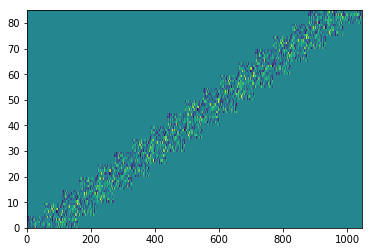

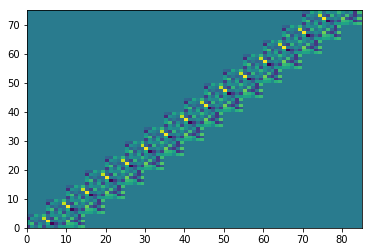

In [230]:
# Visualize the mf_matrix to confirm that it is block diagonal
plt.pcolormesh(mf_matrix)
plt.show()
plt.pcolormesh(mf_matrix2)
plt.show()

We can see from the visualziation above that each block of values (filters) occupies 5 rows (number of filters) and a number of column elements that corresponds to the number of elements that are getting filtered at each step (filter height * filter width). This is what we should get and thereby it indicates correctness of our filter construction